# Wine Price Prediction Project

## Description

This project aims to predict wine prices using a variety of features from a large wine review dataset. We perform data cleaning, exploratory data analysis, feature engineering, and compare several regression models to identify the best approach for price prediction. The workflow includes visualizations and a summary of model performance.

## Table of Contents

1. Library Imports and Data Downloading
2. Basic Cleaning & Filtering
3. Exploratory Data Analysis (EDA)
4. Feature Engineering and Model Setup
5. Model Comparison
6. Model Evaluation and Visualization
7. Summary

## 1) Library Imports and Data Downloading

In [85]:
# %% Imports
import os
import shutil as sh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Set global vars for cell output formatting.
LINE_BREAK = '=' * 50
LOAD_BREAK = '*' * 50


# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [86]:
# %% Download datasets using kagglehub
path = kagglehub.dataset_download("zynicide/wine-reviews")
print(f"{LINE_BREAK}\n1) Path to dataset folder: {path}")

WINE_CSV_TITLE = "winemag-data_first150k.csv"
WINE_CSV_TITLE_2 = "winemag-data-130k-v2.csv"
first_path = os.path.join(path, WINE_CSV_TITLE)
second_path = os.path.join(path, WINE_CSV_TITLE_2)

print(LINE_BREAK)
print(f"2) Moving the CSVs to this directory\n{LOAD_BREAK}")

try:
    sh.move(first_path, ".")
    print(f"File {first_path} has been moved to this directory")
except FileNotFoundError:
    print("File was not found")
except Exception as e:
    print(e)

try:
    sh.move(second_path, ".")
    print(f"File {second_path} has been moved to this directory")
except FileNotFoundError:
    print("File was not found")
except Exception as e:
    print(e)

print(LINE_BREAK)

# %% Reading the dataset
print(f"3) Reading CSV {WINE_CSV_TITLE} and {WINE_CSV_TITLE_2}\n")
df = pd.read_csv(WINE_CSV_TITLE)
df2 = pd.read_csv(WINE_CSV_TITLE_2)

df = pd.concat([df, df2], ignore_index=True)
print("Raw shape:", df.shape)
print("Raw head:")
df.head()


1) Path to dataset folder: C:\Users\prana\.cache\kagglehub\datasets\zynicide\wine-reviews\versions\4
2) Moving the CSVs to this directory
**************************************************
Destination path '.\winemag-data_first150k.csv' already exists
Destination path '.\winemag-data-130k-v2.csv' already exists
3) Reading CSV winemag-data_first150k.csv and winemag-data-130k-v2.csv

Raw shape: (280901, 14)
Raw head:


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


## 2) Basic Cleaning & Filtering

In [87]:
df.info()
print(LINE_BREAK + "\n")
# Combine region_1 and region_2 into a single 'region' column.
# If region_2 is missing, fall back to region_1.
df["region"] = df["region_2"].fillna(df["region_1"])

print(df.isna().sum().sort_values(ascending=False))
print(LINE_BREAK)
df = df.drop(columns=["region_2", "region_1", "taster_name", "taster_twitter_handle", df.columns[0], "title"])

print("Drop unecessary columns and rows with missing data.")
print(LINE_BREAK)
df = df.dropna(subset=["price", "region", "designation"])
null_columns = df.isna().sum().sort_values(ascending=False)
print(null_columns)

print(LINE_BREAK)

# For other important categoricals, fill missing with "Unknown"
fill_cols = ["country", "province", "variety", "region", "designation", "winery", "description"]
for col in fill_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")


# %% Feature construction

# Create log_price as the regression target (to handle skew)
df["log_price"] = np.log1p(df["price"])  # log(1 + price)

print("Log transformation applied to price:")
print(LOAD_BREAK)
print(f"Original price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"Log price range: {df['log_price'].min():.3f} - {df['log_price'].max():.3f}")

# Keep only the columns we care about
# (you can add/remove here if you want to experiment)
needed_cols = [
    "log_price",
    "price",
    "points",
    "country",
    "province",
    "variety",
    "region",
    "description",
    "winery",
]
df = df[needed_cols]

print(LINE_BREAK)
print(f"\nFinal cleaned dataset size: {len(df)} rows")
print(f"Columns kept: {list(df.columns)}")

print("\nCleaned data preview:")
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             280901 non-null  int64  
 1   country                280833 non-null  object 
 2   description            280901 non-null  object 
 3   designation            197701 non-null  object 
 4   points                 280901 non-null  int64  
 5   price                  258210 non-null  float64
 6   province               280833 non-null  object 
 7   region_1               234594 non-null  object 
 8   region_2               111464 non-null  object 
 9   variety                280900 non-null  object 
 10  winery                 280901 non-null  object 
 11  taster_name            103727 non-null  object 
 12  taster_twitter_handle  98758 non-null   object 
 13  title                  129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


,log_price,price,points,country,province,variety,region,description,winery
0,5.463832,235.0,96,US,California,Cabernet Sauvignon,Napa,This tremendous 100% varietal wine hails from ...,Heitz
1,4.709530,110.0,96,Spain,Northern Spain,Tinta de Toro,Toro,"Ripe aromas of fig, blackberry and cassis are ...",Bodega Carmen Rodríguez
2,4.510860,90.0,96,US,California,Sauvignon Blanc,Sonoma,Mac Watson honors the memory of a wine once ma...,Macauley
3,4.189655,65.0,96,US,Oregon,Pinot Noir,Willamette Valley,"This spent 20 months in 30% new French oak, an...",Ponzi
4,4.204693,66.0,95,France,Provence,Provence red blend,Bandol,"This is the top wine from La Bégude, named aft...",Domaine de la Bégude


## 3) Exploratory Data Analysis (EDA)

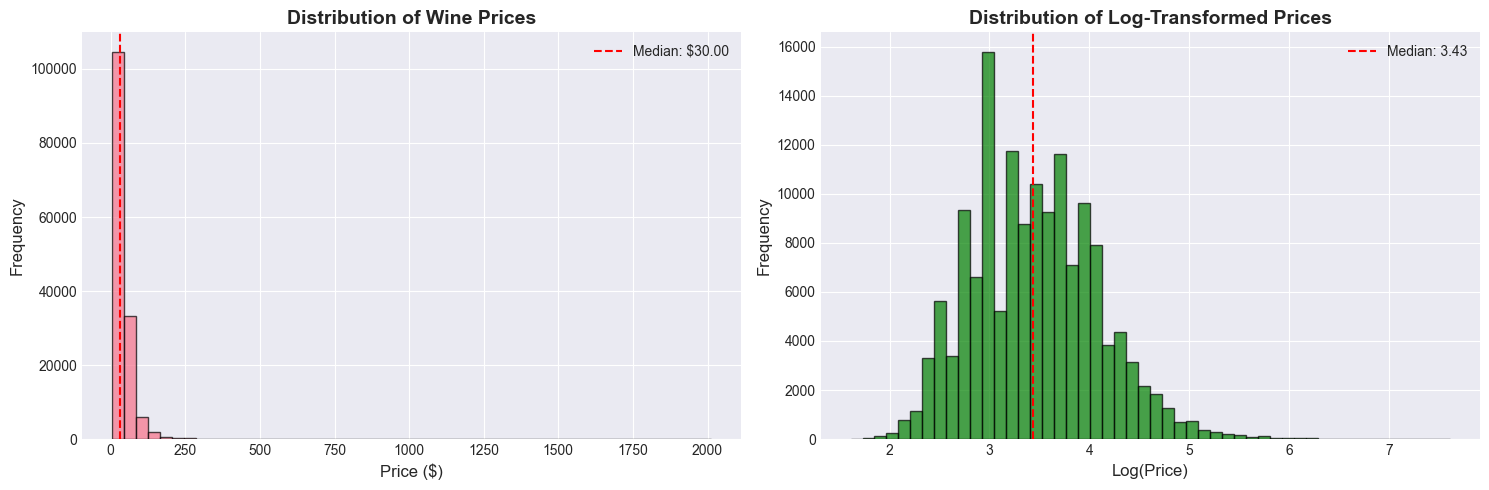

Price Statistics:
  Mean: $38.52
  Median: $30.00
  Std Dev: $36.10
  Skewness: 8.54


In [88]:

# Price distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original price distribution
axes[0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Wine Prices', fontsize=14, fontweight='bold')
axes[0].axvline(df['price'].median(), color='red', linestyle='--', label=f'Median: ${df["price"].median():.2f}')
axes[0].legend()

# Log-transformed price distribution
axes[1].hist(df['log_price'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Log-Transformed Prices', fontsize=14, fontweight='bold')
axes[1].axvline(df['log_price'].median(), color='red', linestyle='--', label=f'Median: {df["log_price"].median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Price Statistics:")
print(f"  Mean: ${df['price'].mean():.2f}")
print(f"  Median: ${df['price'].median():.2f}")
print(f"  Std Dev: ${df['price'].std():.2f}")
print(f"  Skewness: {df['price'].skew():.2f}")


## 4) Feature Engineering and Model Setup

In [89]:
# %% Preprocessing: numeric, categorical, and text
numeric_features = ["points"]
categorical_features = ["country", "province", "variety", "region", "winery"]
text_feature = "description"

for col in categorical_features:
    freq = df[col].value_counts(normalize=True)
    df[col] = df[col].map(freq).astype(float)

print("After frequency encoding the categorical columns\n", tabulate(df.head()))


numeric_transformer = "passthrough"  # points is already numeric

categorical_transformer = "passthrough"
df[categorical_features] = df[categorical_features].fillna(0.0)
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

text_transformer = TfidfVectorizer(
    max_features=2000,
    stop_words="english"
)

# ColumnTransformer will:
# - pass 'points' through
# - one-hot encode country/province/variety/region
# - apply TF-IDF to description
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("text", text_transformer, text_feature),
    ]
)

# %% Train / test split
# Features (X) and target (y). We will predict log_price.
feature_cols = numeric_features + categorical_features + [text_feature]
X = df[feature_cols]
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape, "\n")

After frequency encoding the categorical columns
 -  -------  ---  --  ---------  ----------  -----------  -----------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------
0  5.46383  235  96  0.519595   0.359063    0.0748954    0.0639161    This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.                                 2.71262e-05
1  4.70953

## 5) Model Comparison

In [90]:
# %% Define models we want to try
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.0005, max_iter=5000),
    "RandomForest": RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        n_jobs=-1,
        random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
}

ridge_params = {
    "model__alpha": [0.1, 1.0, 10.0, 50.0]
}

lasso_params = {
    "model__alpha": [0.0001, 0.001, 0.01],
    "model__max_iter": [3000, 5000]
}

rf_params = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [12, 15, 18],
    "model__min_samples_split": [5, 10, 20],
    "model__max_features": ["sqrt"]
}

gbr_params = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [2, 3]
}

param_grids = {
    "Ridge": ridge_params,
    "Lasso": lasso_params,
    "RandomForest": rf_params,
    "GradientBoosting": gbr_params
}

results = []

# %% Train and evaluate each model
for name, model in models.items():
    print(f"\n=== Training {name} ===")

    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", model),
        ]
    )

    best_params = {}
    if name in param_grids:
        print(f"Running GridSearchCV for {name}...")
        grid = GridSearchCV(
            pipe,
            param_grids[name],
            cv=3,
            scoring="neg_mean_squared_error",
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_pipe = grid.best_estimator_
        best_params = grid.best_params_
        print(f"Best params: {best_params}")
    else:
        best_pipe = pipe.fit(X_train, y_train)

    # Predictions in log space
    y_train_pred_log = best_pipe.predict(X_train)
    y_test_pred_log = best_pipe.predict(X_test)

    # Convert back to original price scale
    y_train_price = np.expm1(y_train)
    y_test_price = np.expm1(y_test)

    y_train_pred_price = np.expm1(y_train_pred_log)
    y_test_pred_price = np.expm1(y_test_pred_log)

    train_rmse = root_mean_squared_error(y_train_price, y_train_pred_price)
    test_rmse = root_mean_squared_error(y_test_price, y_test_pred_price)
    train_mae = mean_absolute_error(y_train_price, y_train_pred_price)
    test_mae = mean_absolute_error(y_test_price, y_test_pred_price)
    train_r2 = r2_score(y_train_price, y_train_pred_price)
    test_r2 = r2_score(y_test_price, y_test_pred_price)
    
    print(f"Train RMSE: ${train_rmse:.2f} | Test RMSE: ${test_rmse:.2f}")
    print(f"Train MAE:  ${train_mae:.2f} | Test MAE:  ${test_mae:.2f}")
    print(f"Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    
    results.append({
        "model": name,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "best_params": best_params
    })



=== Training LinearRegression ===


Train RMSE: $29.01 | Test RMSE: $28.31
Train MAE:  $13.19 | Test MAE:  $13.25
Train R²:   0.3589 | Test R²:   0.3664

=== Training Ridge ===
Running GridSearchCV for Ridge...
Best params: {'model__alpha': 1.0}
Train RMSE: $29.05 | Test RMSE: $28.34
Train MAE:  $13.19 | Test MAE:  $13.25
Train R²:   0.3572 | Test R²:   0.3649

=== Training Lasso ===
Running GridSearchCV for Lasso...
Best params: {'model__alpha': 0.0001, 'model__max_iter': 3000}
Train RMSE: $30.01 | Test RMSE: $29.19
Train MAE:  $13.69 | Test MAE:  $13.59
Train R²:   0.3138 | Test R²:   0.3265

=== Training RandomForest ===
Running GridSearchCV for RandomForest...
Best params: {'model__max_depth': 18, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 200}
Train RMSE: $31.54 | Test RMSE: $31.68
Train MAE:  $14.76 | Test MAE:  $15.01
Train R²:   0.2423 | Test R²:   0.2064

=== Training GradientBoosting ===
Running GridSearchCV for GradientBoosting...
Best params: {'model__learning_rate': 

## 6) Model Evaluation and Visualization

In [91]:

# %% Wrap results into a DataFrame for easy viewing
results_df = pd.DataFrame(results).sort_values(by=["test_rmse", "train_rmse", "test_mae", "train_mae", "test_r2", "train_r2"])

print("\n=== Model Comparison (sorted by RMSE) ===")
print(tabulate(results_df))
print(LINE_BREAK)
best_line = results_df.iloc[0]
best_model_name = best_line["model"]
best_params = best_line["best_params"]


best_params = {k.replace("model__", ""): v for k, v in best_params.items()}
print(f"\n The best parameters for {best_model_name} are {best_params}")


=== Model Comparison (sorted by RMSE) ===
-  ----------------  -------  -------  -------  -------  --------  --------  ------------------------------------------------------------------------------------------------------------------
4  GradientBoosting  27.4261  26.6261  12.5404  12.5126  0.426935  0.439502  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
0  LinearRegression  29.0093  28.3101  13.1892  13.2545  0.358866  0.366364  {}
1  Ridge             29.0472  28.3424  13.1931  13.249   0.357187  0.364914  {'model__alpha': 1.0}
2  Lasso             30.0106  29.1867  13.6922  13.5933  0.313842  0.326515  {'model__alpha': 0.0001, 'model__max_iter': 3000}
3  RandomForest      31.5361  31.6818  14.7624  15.0128  0.242309  0.206442  {'model__max_depth': 18, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 200}
-  ----------------  -------  -------  -------  -------  --------  --------  --------------------------------

C:\Users\prana\AppData\Local\Temp\ipykernel_11312\728582109.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(results_df['model'], rotation=45, ha='right')


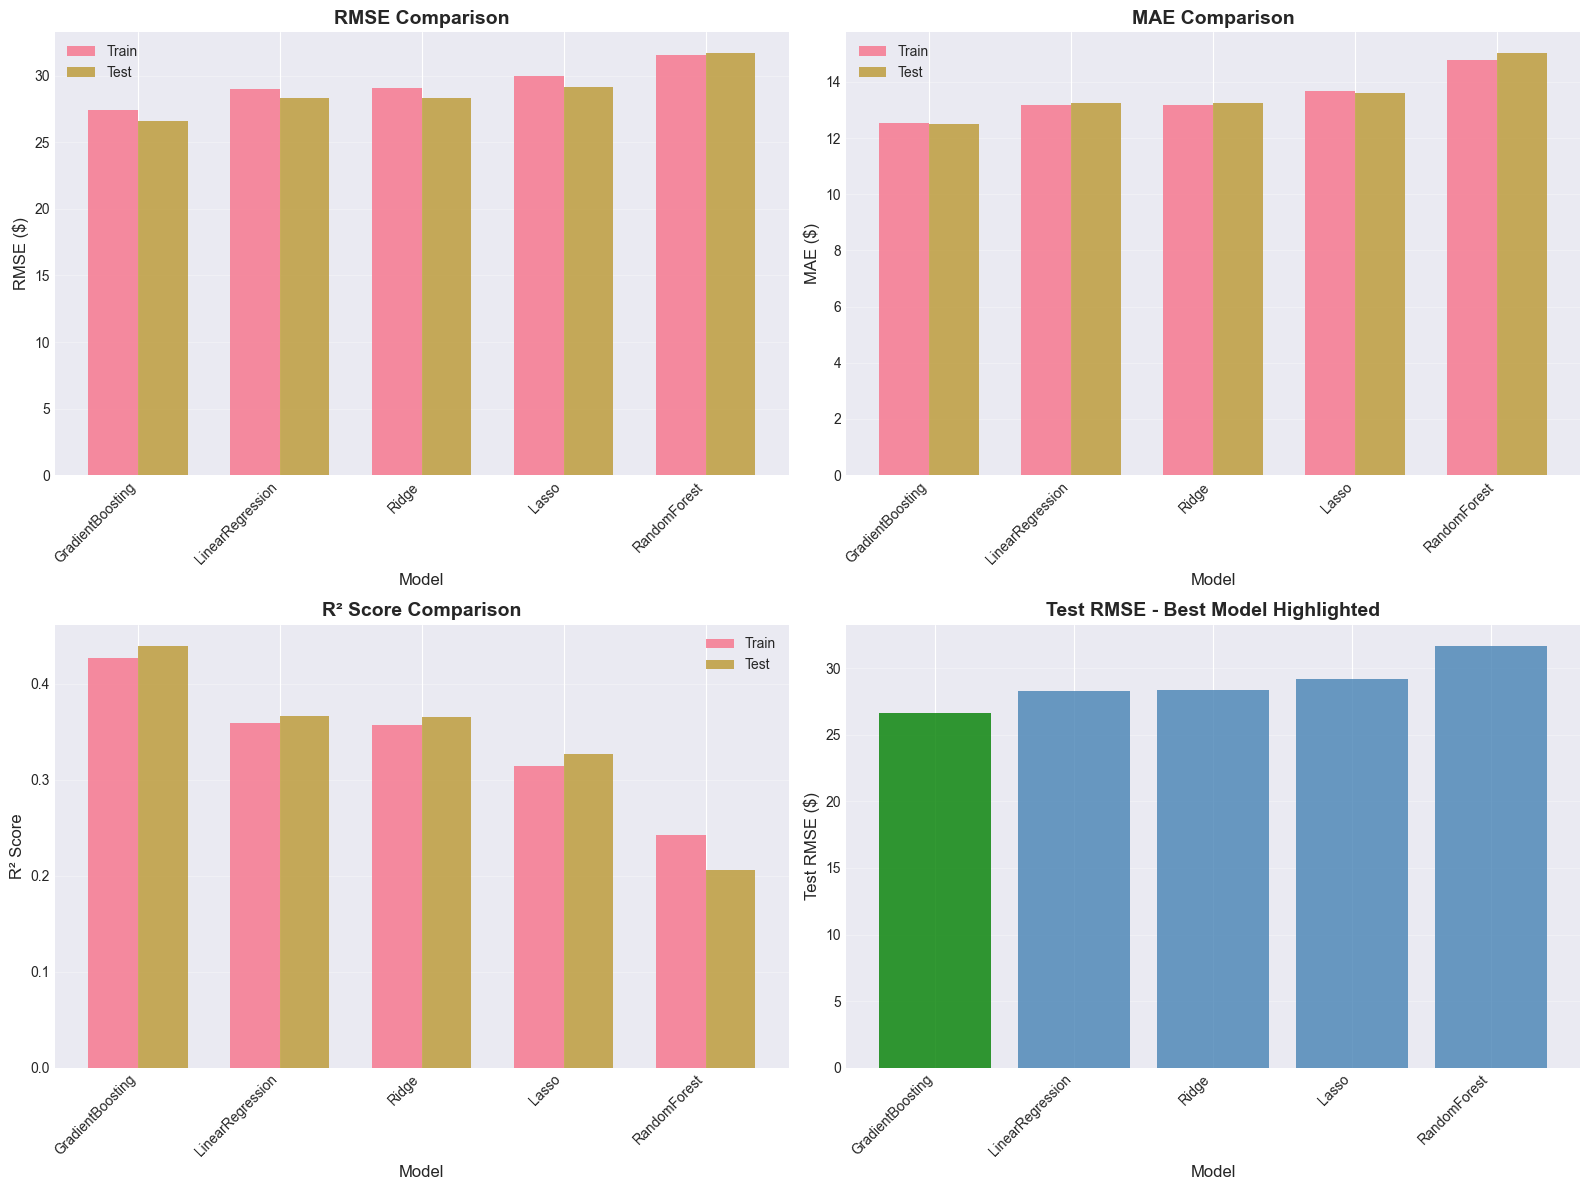

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x = np.arange(len(results_df))
width = 0.35

axes[0, 0].bar(x - width/2, results_df["train_rmse"], width=width, label = "Train", alpha=0.8)
axes[0, 0].bar(x + width/2, results_df["test_rmse"], width=width, label = "Test", alpha=0.8)
axes[0, 0].set_xlabel('Model', fontsize=12)
axes[0, 0].set_ylabel('RMSE ($)', fontsize=12)
axes[0, 0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

axes[0, 1].bar(x - width/2, results_df["train_mae"], width=width, label="Train", alpha=0.8)
axes[0, 1].bar(x + width/2, results_df["test_mae"], width=width, label="Test", alpha=0.8)
axes[0, 1].set_xlabel('Model', fontsize=12)
axes[0, 1].set_ylabel('MAE ($)', fontsize=12)
axes[0, 1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

axes[1, 0].bar(x - width/2, results_df['train_r2'], width, label='Train', alpha=0.8)
axes[1, 0].bar(x + width/2, results_df['test_r2'], width, label='Test', alpha=0.8)
axes[1, 0].set_xlabel('Model', fontsize=12)
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

colors = ['green' if i == 0 else 'steelblue' for i in range(len(results_df))]
axes[1, 1].bar(results_df['model'], results_df['test_rmse'], color=colors, alpha=0.8)
axes[1, 1].set_xlabel('Model', fontsize=12)
axes[1, 1].set_ylabel('Test RMSE ($)', fontsize=12)
axes[1, 1].set_title('Test RMSE - Best Model Highlighted', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


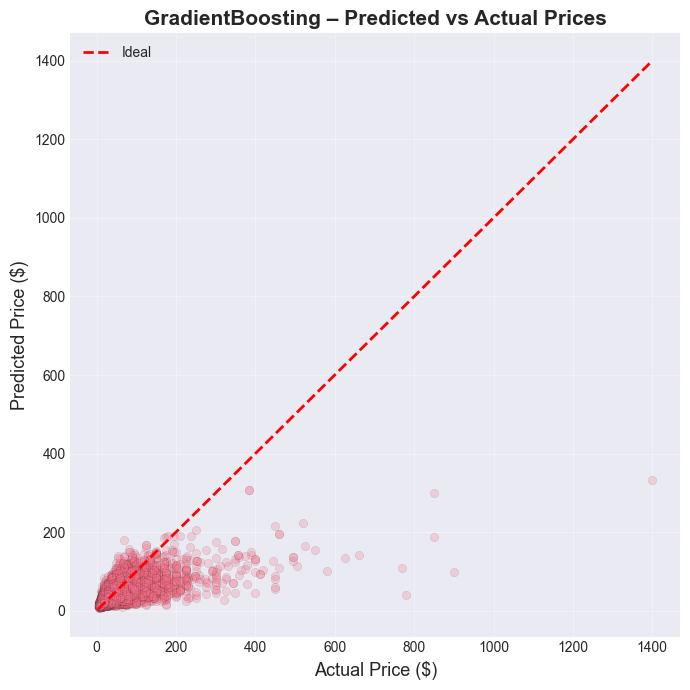

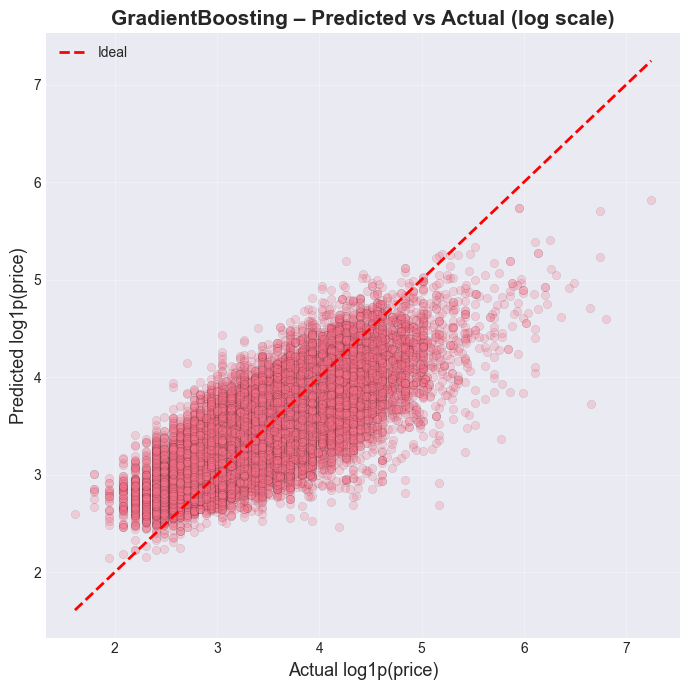

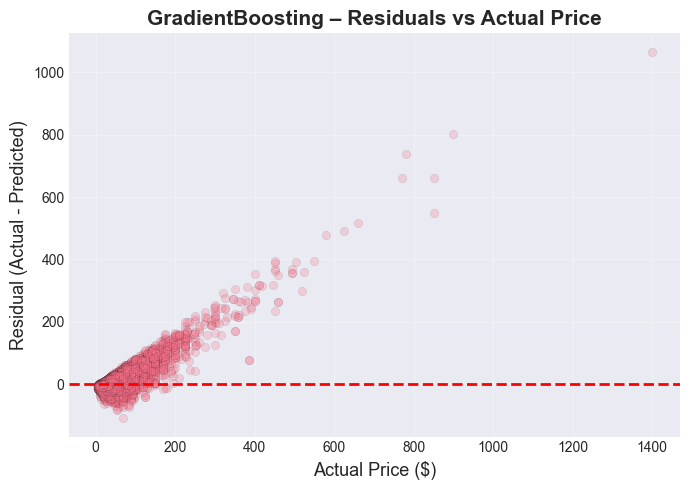

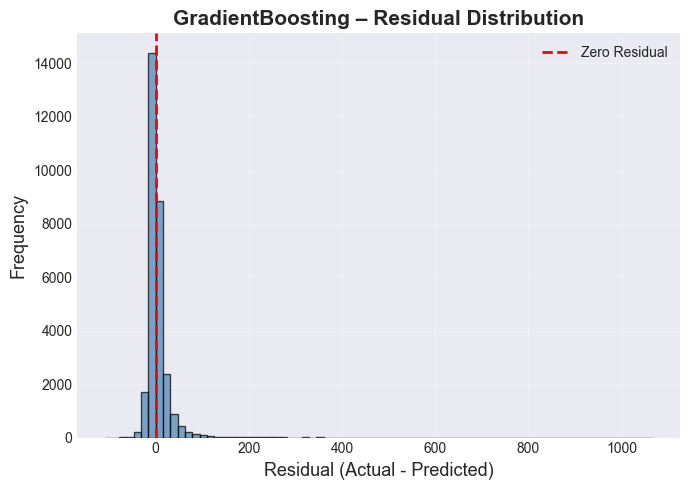

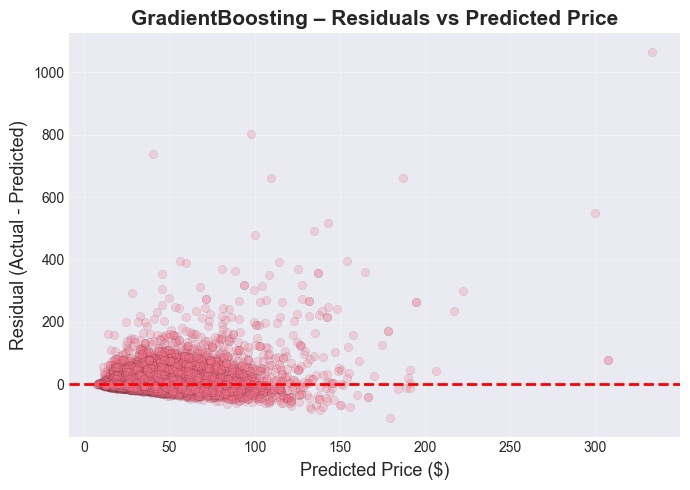

In [93]:

# === Plotting Section ===

match best_model_name:
    case "GradientBoosting":
        plot_model = GradientBoostingRegressor(**best_params)
    case "Ridge":
        plot_model = Ridge(**best_params)
    case "Lasso":
        plot_model = Lasso(**best_params)
    case "RandomForest":
        plot_model = RandomForestRegressor(**best_params)
    case "LinearRegression":
        plot_model = LinearRegression()
# Ensure best model is Linear Regression
best_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                            ("model", plot_model)])
best_pipe.fit(X_train, y_train)

# Predictions
y_pred_log = best_pipe.predict(X_test)
y_pred_price = np.expm1(y_pred_log)
y_test_price = np.expm1(y_test)


# 1. Predicted vs Actual (Price)
plt.figure(figsize=(7, 7))
plt.scatter(y_test_price, y_pred_price, alpha=0.25, edgecolor='k', linewidth=0.2)
plt.plot([y_test_price.min(), y_test_price.max()], [y_test_price.min(), y_test_price.max()], color='red', linestyle='--', linewidth=2, label='Ideal')
plt.xlabel("Actual Price ($)", fontsize=13)
plt.ylabel("Predicted Price ($)", fontsize=13)
plt.title(f"{best_model_name} – Predicted vs Actual Prices", fontsize=15, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Predicted vs Actual (log1p(price))
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_log, alpha=0.25, edgecolor='k', linewidth=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2, label='Ideal')
plt.xlabel("Actual log1p(price)", fontsize=13)
plt.ylabel("Predicted log1p(price)", fontsize=13)
plt.title(f"{best_model_name} – Predicted vs Actual (log scale)", fontsize=15, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Residuals vs Actual Price
residuals = y_test_price - y_pred_price
plt.figure(figsize=(7, 5))
plt.scatter(y_test_price, residuals, alpha=0.25, edgecolor='k', linewidth=0.2)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Price ($)", fontsize=13)
plt.ylabel("Residual (Actual - Predicted)", fontsize=13)
plt.title(f"{best_model_name} – Residuals vs Actual Price", fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Residual Histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=75, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
plt.xlabel("Residual (Actual - Predicted)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title(f"{best_model_name} – Residual Distribution", fontsize=15, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Residuals vs Predicted Price
plt.figure(figsize=(7, 5))
plt.scatter(y_pred_price, residuals, alpha=0.25, edgecolor='k', linewidth=0.2)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Price ($)", fontsize=13)
plt.ylabel("Residual (Actual - Predicted)", fontsize=13)
plt.title(f"{best_model_name} – Residuals vs Predicted Price", fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7) Summary

In [94]:
print(LINE_BREAK)
print("Wine Price Prediction Project – Summary")
print(LINE_BREAK)

print("1. Data Overview:")
print(f"  - Total samples: {len(df)}")
print(f"  - Features used: {feature_cols}")
print(f"  - Target variable: log_price (log1p(price))")
print(f"  - Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(LINE_BREAK)

print("2. Models Evaluated:")
print(tabulate(results_df[["model", "train_rmse", "test_rmse", "train_mae", "test_mae", "train_r2", "test_r2"]], headers="keys", tablefmt="github"))
print(LINE_BREAK)

print("3. Best Model:")
print(f"  - Name: {best_model_name}")
print(f"  - Test RMSE: ${results_df.loc[results_df['model'] == best_model_name, 'test_rmse'].values[0]:.2f}")
print(f"  - Test MAE:  ${results_df.loc[results_df['model'] == best_model_name, 'test_mae'].values[0]:.2f}")
print(f"  - Test R²:   {results_df.loc[results_df['model'] == best_model_name, 'test_r2'].values[0]:.4f}")
print(f"  - Best Parameters: {best_params}")
print(LINE_BREAK)

print("4. Plots Generated:")
print("  - Price and log(price) distributions")
print("  - Model comparison bar charts (RMSE, MAE, R²)")
print("  - Predicted vs Actual prices (scatter)")
print("  - Residual analysis (scatter and histogram)")
print(LINE_BREAK)
print("Project complete. See above for details and visualizations.")

Wine Price Prediction Project – Summary
1. Data Overview:
  - Total samples: 147459
  - Features used: ['points', 'country', 'province', 'variety', 'region', 'winery', 'description']
  - Target variable: log_price (log1p(price))
  - Train samples: 117967, Test samples: 29492
2. Models Evaluated:
|    | model            |   train_rmse |   test_rmse |   train_mae |   test_mae |   train_r2 |   test_r2 |
|----|------------------|--------------|-------------|-------------|------------|------------|-----------|
|  4 | GradientBoosting |      27.4261 |     26.6261 |     12.5404 |    12.5126 |   0.426935 |  0.439502 |
|  0 | LinearRegression |      29.0093 |     28.3101 |     13.1892 |    13.2545 |   0.358866 |  0.366364 |
|  1 | Ridge            |      29.0472 |     28.3424 |     13.1931 |    13.249  |   0.357187 |  0.364914 |
|  2 | Lasso            |      30.0106 |     29.1867 |     13.6922 |    13.5933 |   0.313842 |  0.326515 |
|  3 | RandomForest     |      31.5361 |     31.6818 |     14